# Attempt 1 to optimize the model by increasing number of neurons increasing hidden layers, introducing bins and increased number of epochs to 150

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


343/343 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6298 - loss: 0.6952 - val_accuracy: 0.7274 - val_loss: 0.5658 - learning_rate: 0.0010
Epoch 2/150
343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7005 - loss: 0.5993 - val_accuracy: 0.7347 - val_loss: 0.5552 - learning_rate: 0.0010
Epoch 3/150
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7133 - loss: 0.5781 - val_accuracy: 0.7362 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 4/150
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7164 - loss: 0.5767 - val_accuracy: 0.7383 - val_loss: 0.5512 - learning_rate: 0.0010
Epoch 5/150
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7136 - loss: 0.5737 - val_accuracy: 0.7378 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 6/150
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7234 - loss: 0.5667 - val_accuracy: 0.7376 - val_loss: 0.5478 - learning_rate: 0.0010
Epoch 7/150
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7211 - loss: 0.5663 - val


Test Loss: 0.5580
Test Accuracy: 0.7261


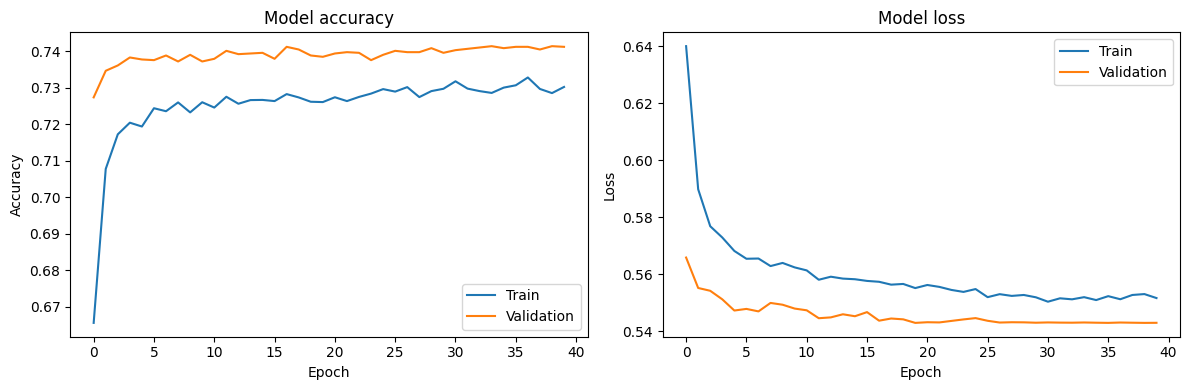

In [7]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import numpy as np


# Import and read the charity_data.csv
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")

# Drop the non-beneficial ID columns, 'EIN' and 'NAME'
application_df = application_df.drop(['EIN', 'NAME'], axis=1)

# Additional feature engineering: Create a binary column for large ASK_AMT
application_df['LARGE_ASK'] = (application_df['ASK_AMT'] > application_df['ASK_AMT'].median()).astype(int)

# Optimize APPLICATION_TYPE binning with more granular approach
application_counts = application_df['APPLICATION_TYPE'].value_counts()
cutoff_application = 200  # Reduced cutoff for more granular categories
application_types_to_replace = application_counts[application_counts < cutoff_application].index
application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(application_types_to_replace, 'Other')

# Optimize CLASSIFICATION binning
classification_counts = application_df['CLASSIFICATION'].value_counts()
cutoff_classification = 800  # Adjusted for better balance
classifications_to_replace = classification_counts[classification_counts < cutoff_classification].index
application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(classifications_to_replace, 'Other')

# Create bins for INCOME_AMT to reduce categories
def categorize_income(income):
    if income == '0':
        return 'No Income'
    elif income in ['1-9999', '10000-24999']:
        return 'Low Income'
    elif income in ['25000-99999', '100000-499999']:
        return 'Medium Income'
    else:
        return 'High Income'

application_df['INCOME_CATEGORY'] = application_df['INCOME_AMT'].apply(categorize_income)
application_df = application_df.drop('INCOME_AMT', axis=1)

# Convert categorical data to numeric with `pd.get_dummies`
categorical_columns = ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION',
                      'USE_CASE', 'ORGANIZATION', 'STATUS', 'SPECIAL_CONSIDERATIONS',
                      'INCOME_CATEGORY']
application_df = pd.get_dummies(application_df, columns=categorical_columns)

# Split preprocessed data into features and target arrays
X = application_df.drop(['IS_SUCCESSFUL'], axis=1)
y = application_df['IS_SUCCESSFUL']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the optimized model
input_features = X_train.shape[1]

model = tf.keras.Sequential([
    # First hidden layer - increased neurons
    tf.keras.layers.Dense(units=80, activation='relu', input_dim=input_features),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # Second hidden layer
    tf.keras.layers.Dense(units=40, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    # Third hidden layer
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    # Fourth hidden layer
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    # Output layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile model with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train the model with increased epochs
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the model
model.save('AlphabetSoupCharity_Optimization.h5')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Attemp 2 to optimze the model, use elu activation instead of RELU for better gradient desecnt flow, Increased network depth to 4 hidden layers (from 3) Increased neurons in each layer (128 → 64 → 32 → 16)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


343/343 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6746 - loss: 0.6314 - val_accuracy: 0.7374 - val_loss: 0.5526 - learning_rate: 0.0010
Epoch 2/200
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7191 - loss: 0.5766 - val_accuracy: 0.7376 - val_loss: 0.5504 - learning_rate: 0.0010
Epoch 3/200
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7203 - loss: 0.5679 - val_accuracy: 0.7363 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 4/200
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7207 - loss: 0.5661 - val_accuracy: 0.7356 - val_loss: 0.5485 - learning_rate: 0.0010
Epoch 5/200
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7298 - loss: 0.5588 - val_accuracy: 0.7367 - val_loss: 0.5478 - learning_rate: 0.0010
Epoch 6/200
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7211 - loss: 0.5645 - val_accuracy: 0.7371 - val_loss: 0.5476 - learning_rate: 0.0010
Epoch 7/200
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7278 - loss: 0.5603 - val


Test Loss: 0.5559
Test Accuracy: 0.7262


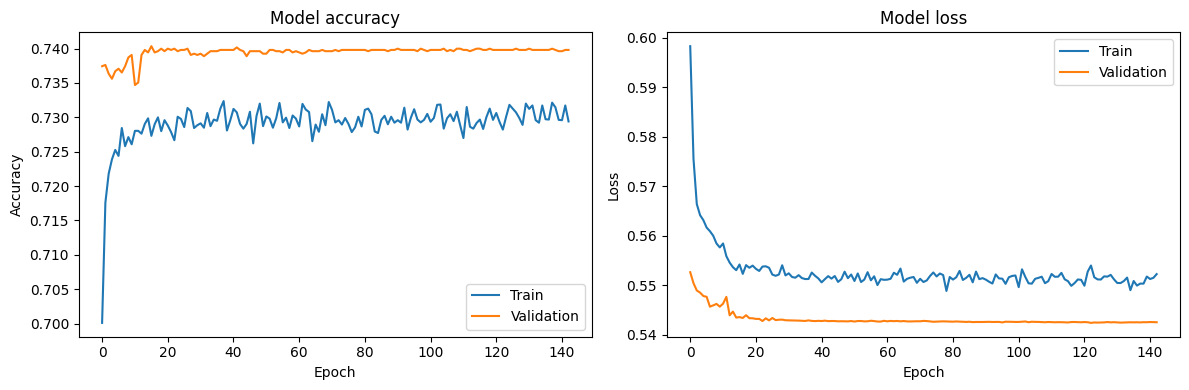

In [11]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import numpy as np


# Import and read the charity_data.csv
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")

# Drop the non-beneficial ID columns, 'EIN' and 'NAME'
application_df = application_df.drop(['EIN', 'NAME'], axis=1)

# Additional feature engineering: Create a binary column for large ASK_AMT
application_df['LARGE_ASK'] = (application_df['ASK_AMT'] > application_df['ASK_AMT'].median()).astype(int)

# Optimize APPLICATION_TYPE binning with more granular approach
application_counts = application_df['APPLICATION_TYPE'].value_counts()
cutoff_application = 200  # Reduced cutoff for more granular categories
application_types_to_replace = application_counts[application_counts < cutoff_application].index
application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(application_types_to_replace, 'Other')

# Optimize CLASSIFICATION binning
classification_counts = application_df['CLASSIFICATION'].value_counts()
cutoff_classification = 800  # Adjusted for better balance
classifications_to_replace = classification_counts[classification_counts < cutoff_classification].index
application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(classifications_to_replace, 'Other')

# Create bins for INCOME_AMT to reduce categories
def categorize_income(income):
    if income == '0':
        return 'No Income'
    elif income in ['1-9999', '10000-24999']:
        return 'Low Income'
    elif income in ['25000-99999', '100000-499999']:
        return 'Medium Income'
    else:
        return 'High Income'

application_df['INCOME_CATEGORY'] = application_df['INCOME_AMT'].apply(categorize_income)
application_df = application_df.drop('INCOME_AMT', axis=1)

# Convert categorical data to numeric with `pd.get_dummies`
categorical_columns = ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION',
                      'USE_CASE', 'ORGANIZATION', 'STATUS', 'SPECIAL_CONSIDERATIONS',
                      'INCOME_CATEGORY']
application_df = pd.get_dummies(application_df, columns=categorical_columns)

# Split preprocessed data into features and target arrays
X = application_df.drop(['IS_SUCCESSFUL'], axis=1)
y = application_df['IS_SUCCESSFUL']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the optimized model
input_features = X_train.shape[1]

model = tf.keras.Sequential([
    # First hidden layer - increased neurons
    tf.keras.layers.Dense(units=128, activation='elu', input_dim=input_features),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # Second hidden layer
    tf.keras.layers.Dense(units=64, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    # Third hidden layer
    tf.keras.layers.Dense(units=32, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    # Fourth hidden layer
    tf.keras.layers.Dense(units=16, activation='elu'),
    tf.keras.layers.BatchNormalization(),

    # Output layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile model with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train the model with increased epochs
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the model
model.save('AlphabetSoupCharity_Optimization.h5')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Attemp 3 to optimize the model. Instead of StandardScaler, used RobustScaler, use tanh function in one of the layers, increase epochs to 250, remianing code is same, increase pateince to 30

Epoch 1/250


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


343/343 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6494 - loss: 0.6422 - val_accuracy: 0.7112 - val_loss: 0.5792 - learning_rate: 0.0010
Epoch 2/250
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6981 - loss: 0.5925 - val_accuracy: 0.7134 - val_loss: 0.5714 - learning_rate: 0.0010
Epoch 3/250
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7008 - loss: 0.5852 - val_accuracy: 0.7150 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 4/250
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7083 - loss: 0.5800 - val_accuracy: 0.7192 - val_loss: 0.5658 - learning_rate: 0.0010
Epoch 5/250
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7094 - loss: 0.5769 - val_accuracy: 0.7177 - val_loss: 0.5752 - learning_rate: 0.0010
Epoch 6/250
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7121 - loss: 0.5719 - val_accuracy: 0.7019 - val_loss: 0.5788 - learning_rate: 0.0010
Epoch 7/250
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7117 - loss: 0.5753 - val


Test Loss: 0.5598
Test Accuracy: 0.7217


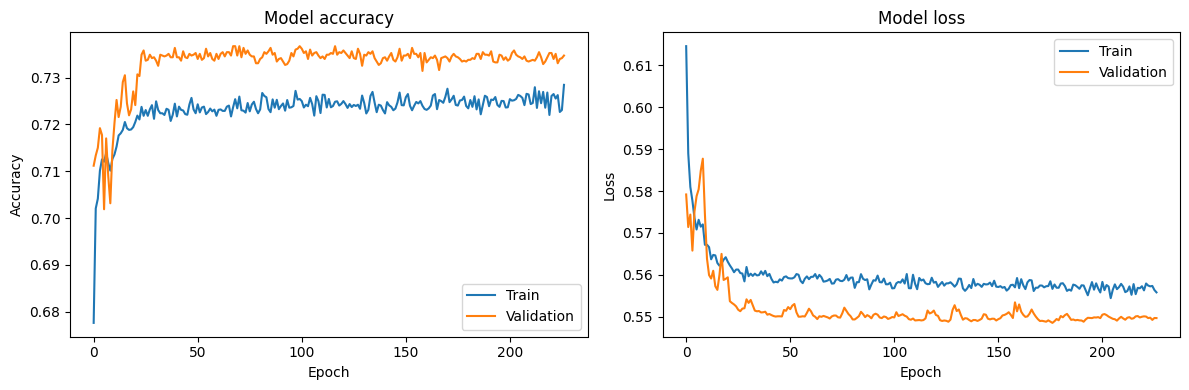

In [12]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import RobustScaler

# Import and read the charity_data.csv
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")

# Drop the non-beneficial ID columns, 'EIN' and 'NAME'
application_df = application_df.drop(['EIN', 'NAME'], axis=1)

# Additional feature engineering: Create a binary column for large ASK_AMT
application_df['LARGE_ASK'] = (application_df['ASK_AMT'] > application_df['ASK_AMT'].median()).astype(int)

# Optimize APPLICATION_TYPE binning with more granular approach
application_counts = application_df['APPLICATION_TYPE'].value_counts()
cutoff_application = 200  # Reduced cutoff for more granular categories
application_types_to_replace = application_counts[application_counts < cutoff_application].index
application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(application_types_to_replace, 'Other')

# Optimize CLASSIFICATION binning
classification_counts = application_df['CLASSIFICATION'].value_counts()
cutoff_classification = 800  # Adjusted for better balance
classifications_to_replace = classification_counts[classification_counts < cutoff_classification].index
application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(classifications_to_replace, 'Other')

# Create bins for INCOME_AMT to reduce categories
def categorize_income(income):
    if income == '0':
        return 'No Income'
    elif income in ['1-9999', '10000-24999']:
        return 'Low Income'
    elif income in ['25000-99999', '100000-499999']:
        return 'Medium Income'
    else:
        return 'High Income'

application_df['INCOME_CATEGORY'] = application_df['INCOME_AMT'].apply(categorize_income)
application_df = application_df.drop('INCOME_AMT', axis=1)

# Convert categorical data to numeric with `pd.get_dummies`
categorical_columns = ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION',
                      'USE_CASE', 'ORGANIZATION', 'STATUS', 'SPECIAL_CONSIDERATIONS',
                      'INCOME_CATEGORY']
application_df = pd.get_dummies(application_df, columns=categorical_columns)

# Split preprocessed data into features and target arrays
X = application_df.drop(['IS_SUCCESSFUL'], axis=1)
y = application_df['IS_SUCCESSFUL']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the optimized model
input_features = X_train.shape[1]

model = tf.keras.Sequential([
    # First hidden layer - increased neurons
    tf.keras.layers.Dense(units=128, activation='elu', input_dim=input_features),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # Second hidden layer
    tf.keras.layers.Dense(units=64, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    # Third hidden layer
    tf.keras.layers.Dense(units=32, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    # Fourth hidden layer
    tf.keras.layers.Dense(units=16, activation='tanh'),
    tf.keras.layers.BatchNormalization(),

    # Output layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile model with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train the model with increased epochs
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=250,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the model
model.save('AlphabetSoupCharity_Optimization.h5')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()